In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV

data = pd.read_csv(r'c:\Users\Kerry\filtered_thyroid_data.csv')
print(data.shape)
data.head()

(383, 13)


,Age,Gender,Hx Radiothreapy,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response,Recurred
0,27,F,No,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Indeterminate,No
1,34,F,No,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
2,30,F,No,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
3,62,F,No,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
4,62,F,No,No,Micropapillary,Multi-Focal,Low,T1a,N0,M0,I,Excellent,No


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383 entries, 0 to 382
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Age              383 non-null    int64 
 1   Gender           383 non-null    object
 2   Hx Radiothreapy  383 non-null    object
 3   Adenopathy       383 non-null    object
 4   Pathology        383 non-null    object
 5   Focality         383 non-null    object
 6   Risk             383 non-null    object
 7   T                383 non-null    object
 8   N                383 non-null    object
 9   M                383 non-null    object
 10  Stage            383 non-null    object
 11  Response         383 non-null    object
 12  Recurred         383 non-null    object
dtypes: int64(1), object(12)
memory usage: 39.0+ KB


In [3]:
data.isnull().sum()

Age                0
Gender             0
Hx Radiothreapy    0
Adenopathy         0
Pathology          0
Focality           0
Risk               0
T                  0
N                  0
M                  0
Stage              0
Response           0
Recurred           0
dtype: int64

In [4]:
data.duplicated().sum()

53

In [5]:
data = data.drop_duplicates()

In [6]:
data.describe()

,Age
count,330.000000
mean,42.157576
std,15.626706
min,15.000000
25%,30.000000
50%,39.000000
75%,53.000000
max,82.000000


### Support Vector Machine

In [14]:
df_encoded = data.copy()
label_encoders = {}

# Encode the target variable
le_target = LabelEncoder()
df_encoded['Focality'] = le_target.fit_transform(df_encoded['Focality'])

# Encode categorical features
categorical_cols = ['Gender', 'Hx Radiothreapy', 'Adenopathy', 'Pathology', 'Risk']
for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le

# Features and targets
X = df_encoded.drop(columns=['T', 'N', 'M', 'Stage', 'Response', 'Recurred'])
y = df_encoded['Focality']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Grid searcg for best svm polynomial parameters
param_grid = {
    'C': [1],
    'degree': [2],
    'gamma': ['scale'],
    'kernel': ['poly']
}

grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model from grid search
svm_model = grid_search.best_estimator_

# Predict and evaluate
y_pred = svm_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(
    y_test,
    y_pred,
    labels=np.unique(y_pred), 
    target_names=le_target.inverse_transform(np.unique(y_pred)))

# Results
print("Best parameters:", grid_search.best_params_)
print("\nConfusion matrix:\n", conf_matrix)
print("\nClassification report:\n", class_report)


Best parameters: {'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}

Confusion matrix:
 [[24  3]
 [ 1 38]]

Classification report:
               precision    recall  f1-score   support

 Multi-Focal       0.96      0.89      0.92        27
   Uni-Focal       0.93      0.97      0.95        39

    accuracy                           0.94        66
   macro avg       0.94      0.93      0.94        66
weighted avg       0.94      0.94      0.94        66



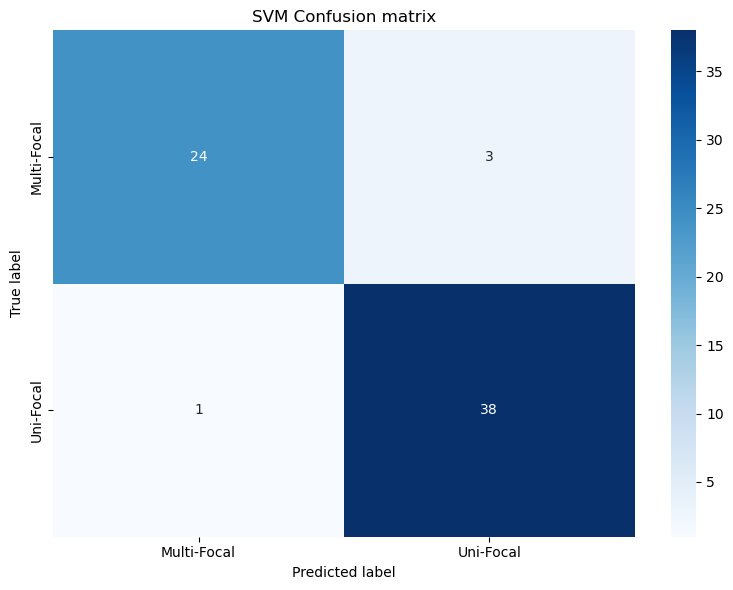

In [16]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_target.classes_,
            yticklabels=le_target.classes_)
plt.title("SVM Confusion matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()